# Option Portfolio Risk Analysis

The following generates a risk analysis for a portfolio of options. The main parameters that are modified are implied volatility and the underlying asset valuation. The model uses a standard Black Scholes pricing for American options, ignoring dividends, and provides a theoretical price for each option under various input scenarious. Theoretical profit/loss is generated as a result of this model. It was calibrated using a mock portfolio but any portfolio of options with the appropriate adjustments can be analyzed.

2018-06-19

-Daniel J. Vera, Ph.D.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
from datetime import datetime
from dateutil.parser import parse
from scipy.stats import norm
pd.set_option('display.max_columns', 500)

### Functions

In [2]:
# Black Scholes Pricing Function For Single Security
def black_scholes(S, K, opt_expire_dt, vol, r=0.0288, opt_type='option_call'):
    '''
    Calculates the theoretical Black Scholes price
    for a put or call option and assumes time to maturity
    from today until expiration
    
    Arguments:
    S -- underlying spot price (float)
    K -- option strike price (float)
    r -- risk-free rate (float)
    opt_expire_dt -- date of expiration (string of date in ISO-8601)
    vol -- implied option volatility (float)
    opt_type -- specification of put or call (string): 'c' or 'p',
                returns None if not specified
    
    Returns:
    option price as float
    '''
    expiration = datetime.strptime(opt_expire_dt, "%Y-%m-%d")
    time_to_expiry = expiration - datetime.today()
    t = (time_to_expiry.days) / 365
    d1 = (np.log(S / K) + (r + (vol**2 / 2)) * t) / (vol * np.sqrt(t))
    d1 = np.asscalar(d1)
    d2 = d1 - (vol * np.sqrt(t))
    d2 = np.asscalar(d2)
    discount_K = (K * np.exp(-r * t))
    N_d1 = norm.cdf(d1)
    N_neg_d1 = norm.cdf(-d1)
    N_d2 = norm.cdf(d2)
    N_neg_d2 = norm.cdf(-d2)
                      
    if opt_type == 'option_call':
        return S * N_d1 - discount_K * N_d2
    elif opt_type == 'option_put':
        return N_neg_d2 * discount_K - N_neg_d1 * S
    else:
        raise Exception('Incorrect option type specified.')

In [3]:
# Black Scholes Pricing Function Vectorized
def black_scholes_vector(S, K, opt_expire_dt, vol, r=0.0288, opt_type='option_call'):
    '''
    Calculates the theoretical Black Scholes price on multiple
    put or call options and assumes data for each security is 
    in a series and the series are all aligned; time to maturity
    is assumed as from today until expiration
    
    Arguments:
    S -- underlying spot price (pandas Series)
    K -- option strike price (pandas Series, same length as S)
    r -- risk-free rate (float, can be broadcast)
    opt_expire_dt -- date of expiration (Series of strings with date in ISO-8601)
    vol -- implied option volatility (pandas Series of length len(S))
    opt_type -- Seires with specifications of put or call (string)
                    
    Returns:
    numpy array of option prices based on parameters and Black Scholes.
    '''
    assert len(S) == len(K)
    assert len(opt_expire_dt) == len(S)
    assert len(vol) == len(S)
    assert len(opt_type) == len(S)
    
    expiration = pd.to_datetime(opt_expire_dt)
    time_to_expiry = expiration - datetime.today()
    t = (time_to_expiry.apply(lambda x: x.days)) / 365
    d1 = (np.log(S.astype(float) / K.astype(float)) + (r + (np.power(vol.astype(float), 2) / 2)) * t) / (vol * np.sqrt(t))
    d2 = d1 - (vol * np.sqrt(t))
    discount_K = (K * np.exp(-r * t))
    N_d1 = d1.apply(lambda x: norm.cdf(x))
    N_neg_d1 = (-d1).apply(lambda x: norm.cdf(x))
    N_d2 = d2.apply(lambda x: norm.cdf(x))
    N_neg_d2 = (-d2).apply(lambda x: norm.cdf(x))
    
    px_if_put = N_neg_d2 * discount_K - N_neg_d1 * S
    px_if_call = S * N_d1 - discount_K * N_d2
    
    black_scholes_prices = np.where(opt_type =='option_call',
                                    px_if_call,
                                    px_if_put)
    return black_scholes_prices

### Load Data

In [4]:
# Load Data for analysis
data = pd.read_excel('portfolio_data_20180712.xlsx') # entire portfolio
options = data.loc[data.security_type.isin(['option_call', 'option_put'])] #options only

The fields used in the data are:
    - ticker
    - underlying
    - name
    - date
    - broker
    - sector
    - security_type
    - long_short
    - quantity
    - underlying_px
    - strike
    - unit_cost
    - bid
    - ask
    - price
    - cost
    - market_value
    - notional
    - delta_notional
    - profit_loss
    - implied_vol
    - option_exipre_dt

In [5]:
# check the data
options.head()

,ticker,underlying,name,date,broker,sector,security_type,long_short,quantity,underlying_px,strike,unit_cost,bid,ask,price,cost,market_value,notional,delta_notional,profit_loss,implied_vol,option_expire_dt
149,ADSK US 01/18/19 C165 Equity,ADSK US,January 19 Calls on ADSK US,2018-01-23,Goldman,Information Technology,option_call,S,-107.0,135.85,165,2.489813,2.96,3.20,3.080,-26641.0,-32956.0,1765500,-335194,-17764.0,0.314305,2019-01-18
150,ADSK US 01/18/19 C175 Equity,ADSK US,January 19 Calls on ADSK US,2018-03-13,Goldman,Information Technology,option_call,S,-90.0,135.85,175,5.650000,1.52,1.86,1.690,-50850.0,-15210.0,1575000,-204370,26910.0,0.306204,2019-01-18
151,ADSK US 01/18/19 C190 Equity,ADSK US,January 19 Calls on ADSK US,2018-03-13,Goldman,Information Technology,option_call,L,200.0,135.85,190,3.426500,0.67,1.04,0.855,68530.0,17100.0,3800000,218088,-42130.0,0.30944,2019-01-18
152,AGN US 01/18/19 P115 Equity,AGN US,January 19 Puts on AGN US,2018-04-16,MS,Health Care,option_put,L,200.0,183.99,115,2.830000,0.5,0.58,0.540,56600.0,10800.0,2300000,-155855,-38200.0,0.377487,2019-01-18
153,AGN US 01/18/19 P130 Equity,AGN US,January 19 Puts on AGN US,2018-04-16,MS,Health Care,option_put,S,-100.0,183.99,130,4.300000,0.9,1.07,0.985,-43000.0,-9850.0,1300000,145729,26000.0,0.334257,2019-01-18


### Clean up data

If needed, we drop options expiring tomorrow to prevent blow up of Black Scholes
options = options.drop(options[options['option_expire_dt'] == '2018-06-22'].index). Adjust the date as appropriate, can use 
tomorrow = datetime.date.today() + datetime.timedelta(days=1); you may have to change the import above but I usually just manually type in date if needed and usually I don't do this analysis near expiration dates, hence the next cell being commented out.

We also make na in data as pandas na

In [6]:
#options.drop(options[options['option_expire_dt'] == '2018-06-22'].index)

In [7]:
options = options.replace('na', np.NaN)

### Calculate

In [8]:
# Calculate base theoretical price of options as numpy array
bs_price = black_scholes_vector(S=options.underlying_px,
                                K=options.strike,
                                opt_expire_dt=options.option_expire_dt,
                                vol=options.implied_vol,
                                opt_type=options.security_type)

In [9]:
# Reset index of option DataFrame
options = options.reset_index().drop('index', axis=1)

In [10]:
# Cast results of black_scholes_vector as DataFrame to join column
bs_theory_px = pd.DataFrame(bs_price, columns=['bs_theoretical_px'])

In [11]:
# join column, ensure axis aligned; we use join instead of pd.merge since the index
# for options has ben reset and matches bs_theory_px now.
options_bs = options.join(bs_theory_px)

In [12]:
display(options_bs.head(), options_bs.tail()) # check

,ticker,underlying,name,date,broker,sector,security_type,long_short,quantity,underlying_px,strike,unit_cost,bid,ask,price,cost,market_value,notional,delta_notional,profit_loss,implied_vol,option_expire_dt,bs_theoretical_px
0,ADSK US 01/18/19 C165 Equity,ADSK US,January 19 Calls on ADSK US,2018-01-23,Goldman,Information Technology,option_call,S,-107.0,135.85,165.0,2.489813,2.96,3.20,3.080,-26641.0,-32956.0,1765500,-335194.403443,-17764.0,0.314305,2019-01-18,3.280926
1,ADSK US 01/18/19 C175 Equity,ADSK US,January 19 Calls on ADSK US,2018-03-13,Goldman,Information Technology,option_call,S,-90.0,135.85,175.0,5.650000,1.52,1.86,1.690,-50850.0,-15210.0,1575000,-204369.864246,26910.0,0.306204,2019-01-18,1.804515
2,ADSK US 01/18/19 C190 Equity,ADSK US,January 19 Calls on ADSK US,2018-03-13,Goldman,Information Technology,option_call,L,200.0,135.85,190.0,3.426500,0.67,1.04,0.855,68530.0,17100.0,3800000,218087.922742,-42130.0,0.309440,2019-01-18,0.813951
3,AGN US 01/18/19 P115 Equity,AGN US,January 19 Puts on AGN US,2018-04-16,MS,Health Care,option_put,L,200.0,183.99,115.0,2.830000,0.50,0.58,0.540,56600.0,10800.0,2300000,-155854.866420,-38200.0,0.377487,2019-01-18,0.372857
4,AGN US 01/18/19 P130 Equity,AGN US,January 19 Puts on AGN US,2018-04-16,MS,Health Care,option_put,S,-100.0,183.99,130.0,4.300000,0.90,1.07,0.985,-43000.0,-9850.0,1300000,145729.383120,26000.0,0.334257,2019-01-18,0.749505


,ticker,underlying,name,date,broker,sector,security_type,long_short,quantity,underlying_px,strike,unit_cost,bid,ask,price,cost,market_value,notional,delta_notional,profit_loss,implied_vol,option_expire_dt,bs_theoretical_px
391,XOM US 06/21/19 P47.5 Equity,XOM US,June 19 Puts on XOM US,2018-04-27,MS,Energy,option_put,S,-500.0,80.20,47.5,0.350000,0.17,0.22,0.195,-17500.000000,-9750.0,2375000,99170.015595,5500.000000,0.296825,2019-06-21,0.145622
392,XOP US 01/18/19 P39 Equity,XOP US,January 19 Puts on XOP US,2018-05-17,MS,Energy,option_put,S,-500.0,41.38,39.0,1.870000,1.86,1.90,1.880,-93500.000000,-94000.0,1950000,622397.681250,4250.000000,0.306972,2019-01-18,2.006080
393,XOP US 01/18/19 P40 Equity,XOP US,January 19 Puts on XOP US,2018-05-17,MS,Energy,option_put,S,-486.0,41.38,40.0,2.227160,2.25,2.29,2.270,-108239.999814,-110322.0,1944000,687925.069088,5450.999814,0.301895,2019-01-18,2.373290
394,XRAY US 10/19/18 P35 Equity,XRAY US,October 18 Puts on XRAY US,2018-04-25,MS,Health Care,option_put,L,400.0,40.36,35.0,0.450000,0.20,0.30,0.250,18000.000000,10000.0,1400000,-109472.448124,-10000.000000,0.337310,2018-10-19,0.458723
395,XRAY US 10/19/18 P40 Equity,XRAY US,October 18 Puts on XRAY US,2018-04-25,MS,Health Care,option_put,S,-400.0,40.36,40.0,0.755875,1.35,1.55,1.450,-30235.000000,-58000.0,1600000,348627.646120,235.000000,0.301768,2018-10-19,1.833478


### Model

In [13]:
# Model inputs can be adjusted here if desired.
model_inputs = pd.DataFrame({
    'spot_drop': [.05, .1, .15, .2, .25],
    'volatility_increase': [.1, .15, .2, .25, .5]
})

# Can also use:
import itertools

spot_drops = [.05, .1, .15, .2, .25]
volty_spikes = [.1, .15, .2, .25, .5]
scenarios = [pair for pair in itertools.product(spot_drops, volty_spikes)]

In [14]:
bs_model_prices = {}
for i, row in enumerate(model_inputs.values):
    bs_price = black_scholes_vector(S=(options.underlying_px) * (1 - row[0]),
                                K=options.strike,
                                opt_expire_dt=options.option_expire_dt,
                                vol=options.implied_vol * (1 + row[1]),
                                opt_type=options.security_type)
    bs_model_prices[
        'spot drop: ' + str(row[0]) + ' ' +
        'vol increase: ' + str(row[1])
    ] = bs_price

In [15]:
bs_model_prices = pd.DataFrame(bs_model_prices)
bs_model_prices.reset_index(drop=True)

,spot drop: 0.05 vol increase: 0.1,spot drop: 0.1 vol increase: 0.15,spot drop: 0.15 vol increase: 0.2,spot drop: 0.2 vol increase: 0.25,spot drop: 0.25 vol increase: 0.5
0,2.686198,1.908102,1.326046,0.898315,1.174463
1,1.499831,1.039791,0.704777,0.465147,0.679130
2,0.714446,0.493749,0.333851,0.219890,0.377954
3,0.975331,1.754538,2.930451,4.599897,8.963869
4,1.786313,3.099017,4.998362,7.585743,13.203927
5,0.135796,0.300451,0.592808,1.063067,2.242588
6,17.779267,14.642904,11.791202,9.258815,8.047071
7,0.394384,0.591010,0.848138,1.173569,2.441819
8,0.193874,0.383835,0.698073,1.182547,2.775786
9,4.706507,8.402369,14.021407,22.112470,50.756794


In [16]:
options_bs = options.join(bs_model_prices)

In [17]:
display(options_bs.head(), options_bs.tail())

,ticker,underlying,name,date,broker,sector,security_type,long_short,quantity,underlying_px,strike,unit_cost,bid,ask,price,cost,market_value,notional,delta_notional,profit_loss,implied_vol,option_expire_dt,spot drop: 0.05 vol increase: 0.1,spot drop: 0.1 vol increase: 0.15,spot drop: 0.15 vol increase: 0.2,spot drop: 0.2 vol increase: 0.25,spot drop: 0.25 vol increase: 0.5
0,ADSK US 01/18/19 C165 Equity,ADSK US,January 19 Calls on ADSK US,2018-01-23,Goldman,Information Technology,option_call,S,-107.0,135.85,165.0,2.489813,2.96,3.20,3.080,-26641.0,-32956.0,1765500,-335194.403443,-17764.0,0.314305,2019-01-18,2.686198,1.908102,1.326046,0.898315,1.174463
1,ADSK US 01/18/19 C175 Equity,ADSK US,January 19 Calls on ADSK US,2018-03-13,Goldman,Information Technology,option_call,S,-90.0,135.85,175.0,5.650000,1.52,1.86,1.690,-50850.0,-15210.0,1575000,-204369.864246,26910.0,0.306204,2019-01-18,1.499831,1.039791,0.704777,0.465147,0.679130
2,ADSK US 01/18/19 C190 Equity,ADSK US,January 19 Calls on ADSK US,2018-03-13,Goldman,Information Technology,option_call,L,200.0,135.85,190.0,3.426500,0.67,1.04,0.855,68530.0,17100.0,3800000,218087.922742,-42130.0,0.309440,2019-01-18,0.714446,0.493749,0.333851,0.219890,0.377954
3,AGN US 01/18/19 P115 Equity,AGN US,January 19 Puts on AGN US,2018-04-16,MS,Health Care,option_put,L,200.0,183.99,115.0,2.830000,0.50,0.58,0.540,56600.0,10800.0,2300000,-155854.866420,-38200.0,0.377487,2019-01-18,0.975331,1.754538,2.930451,4.599897,8.963869
4,AGN US 01/18/19 P130 Equity,AGN US,January 19 Puts on AGN US,2018-04-16,MS,Health Care,option_put,S,-100.0,183.99,130.0,4.300000,0.90,1.07,0.985,-43000.0,-9850.0,1300000,145729.383120,26000.0,0.334257,2019-01-18,1.786313,3.099017,4.998362,7.585743,13.203927


,ticker,underlying,name,date,broker,sector,security_type,long_short,quantity,underlying_px,strike,unit_cost,bid,ask,price,cost,market_value,notional,delta_notional,profit_loss,implied_vol,option_expire_dt,spot drop: 0.05 vol increase: 0.1,spot drop: 0.1 vol increase: 0.15,spot drop: 0.15 vol increase: 0.2,spot drop: 0.2 vol increase: 0.25,spot drop: 0.25 vol increase: 0.5
391,XOM US 06/21/19 P47.5 Equity,XOM US,June 19 Puts on XOM US,2018-04-27,MS,Energy,option_put,S,-500.0,80.20,47.5,0.350000,0.17,0.22,0.195,-17500.000000,-9750.0,2375000,99170.015595,5500.000000,0.296825,2019-06-21,0.377954,0.669562,1.105951,1.722821,3.460630
392,XOP US 01/18/19 P39 Equity,XOP US,January 19 Puts on XOP US,2018-05-17,MS,Energy,option_put,S,-500.0,41.38,39.0,1.870000,1.86,1.90,1.880,-93500.000000,-94000.0,1950000,622397.681250,4250.000000,0.306972,2019-01-18,3.086853,4.203041,5.495712,6.948427,8.959388
393,XOP US 01/18/19 P40 Equity,XOP US,January 19 Puts on XOP US,2018-05-17,MS,Energy,option_put,S,-486.0,41.38,40.0,2.227160,2.25,2.29,2.270,-108239.999814,-110322.0,1944000,687925.069088,5450.999814,0.301895,2019-01-18,3.552798,4.761276,6.140383,7.670769,9.714028
394,XRAY US 10/19/18 P35 Equity,XRAY US,October 18 Puts on XRAY US,2018-04-25,MS,Health Care,option_put,L,400.0,40.36,35.0,0.450000,0.20,0.30,0.250,18000.000000,10000.0,1400000,-109472.448124,-10000.000000,0.337310,2018-10-19,1.007220,1.724302,2.699291,3.928138,5.687741
395,XRAY US 10/19/18 P40 Equity,XRAY US,October 18 Puts on XRAY US,2018-04-25,MS,Health Care,option_put,S,-400.0,40.36,40.0,0.755875,1.35,1.55,1.450,-30235.000000,-58000.0,1600000,348627.646120,235.000000,0.301768,2018-10-19,3.054153,4.431790,6.025708,7.782350,9.773347


In [18]:
# Can save this back to csv if desired:
# options_bs.to_csv('options_risk_models.csv')

### Graphs

After we obtain a summary of the theoretical profit and loss under different scenarios, we can produce graphs to give more insight. We simply load from a previous one to demonstrate the graphs but the user can modify the code for their analysis if they wish.

In [19]:
scenarios = pd.read_excel('scenario_matrix_loss_20180712.xlsx')

In [20]:
scenarios.set_index('drop')

,vol increase 0.1,vol increase 0.15,vol increase 0.2,vol increase 0.25,vol increase 0.5
drop,,,,,
0.05,-3.482129e+05,-1.328797e+06,-2.363566e+06,-3.449810e+06,-9.556935e+06
0.10,-9.231774e+05,-1.975772e+06,-3.079976e+06,-4.232725e+06,-1.062184e+07
0.15,-2.417599e+06,-3.539385e+06,-4.708583e+06,-5.922009e+06,-1.254986e+07
0.20,-4.952856e+06,-6.137626e+06,-7.363835e+06,-8.628484e+06,-1.543397e+07


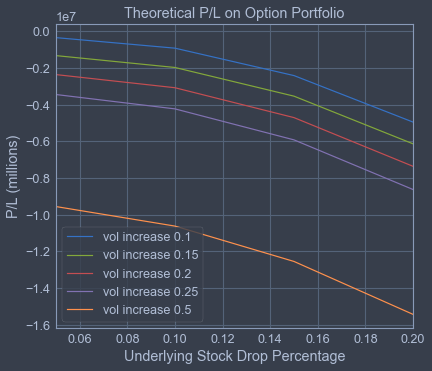

In [21]:
ax1 = scenarios.plot(title='Theoretical P/L on Option Portfolio',
                     x='drop')
ax1.set_ylabel('P/L (millions)')
ax1.set_xlabel('Underlying Stock Drop Percentage')

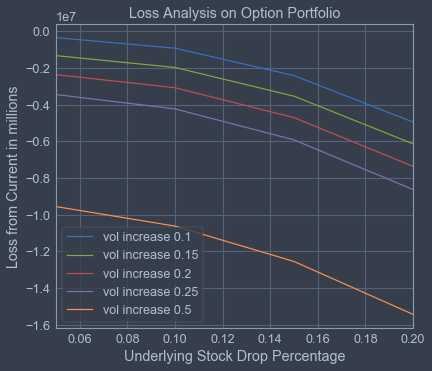

In [22]:
scenarios_loss = pd.read_excel('scenario_matrix_loss_20180712.xlsx')
scenarios_loss.set_index('drop')
ax2 = scenarios_loss.plot(title='Loss Analysis on Option Portfolio',
                     x='drop')
ax2.set_ylabel('Loss from Current in millions')
ax2.set_xlabel('Underlying Stock Drop Percentage')

### Underlyer Analysis
Next we can identify which underlying stock has the greatest risk for particular scenarios according to this particular analysis.

In [23]:
scenario1 = pd.read_excel('Scenario1_20180619.xlsx')
scenario1['pnl_difference'] = scenario1['Theoretical P/L'] - scenario1['P/L (Based on Mid)']
underlyers = scenario1.pivot_table(index=['Underlying'], aggfunc=sum).sort_values(['pnl_difference'])

In [24]:
underlyers.iloc[0:10, -1]

Underlying
GE US      -725409.687630
COWTF US   -580619.052083
EWW US     -325596.854087
XOP US     -296819.718832
WYNN US    -245609.878110
DB US      -243140.585836
FLR US     -201836.410617
TGT US     -201326.653835
NVDA US    -188059.885044
EWZ US     -185610.827700
Name: pnl_difference, dtype: float64

Although the above data is from a mock data set, this analysis would theoretically allow one to focus on the most risky options of the top 10 most risky stocks for a particular scenario.